In [107]:
# DATA CLEANING
import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106


In [146]:
# DATASET TRANSACTIONS
# Diviser les events entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux afin de calculer le temps passé entre 2 actions successives
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# time_diff est moins de 24h et le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
inner_merged_total['event_diff_second'] = inner_merged_total['date_x'] - inner_merged_total['date_y']
inner_merged_total['event_diff_second'] = inner_merged_total['event_diff_second'] / np.timedelta64(1, 's')

# 24h
transaction_24h = inner_merged_total.loc[inner_merged_total['event_diff_second'] < 86400]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Supprimer des events après transactions 
transaction_made_24h = transaction_made_24h.loc[transaction_made_24h.event_diff_second >= 0]
transaction_made_24h

# VERIFICATION
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 9725]

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,event_diff_second
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,1342.792
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,921.539
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,912.906
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,112.193
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,93.809
...,...,...,...,...,...,...,...,...,...
9743949,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 00:57:13.885,851.739
9743946,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:00:26.861,658.763
9743942,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,490.954
9743943,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,349.900


In [171]:
# Grouper par le transactionid et la date d'evenement
calcul_time = pd.DataFrame(transaction_made_24h,columns=['transactionid_x','visitorid','date_y'])
calcul_time['time_diff_sec'] = calcul_time.sort_values(['transactionid_x','date_y']).groupby('transactionid_x')['date_y'].diff()

# Convertir le format timedelta en second
calcul_time['time_diff_sec'] = calcul_time['time_diff_sec'] / np.timedelta64(1, 's')

# Remplacer valeur NaN par 0
calcul_time['time_diff_sec'] = calcul_time['time_diff_sec'].fillna(0)
calcul_time

# VERIFICATION
#calcul_time.loc[calcul_time.transactionid_x == 10800]
#df.loc[(df.visitorid == 186) & (df.itemid == 49029)]




,transactionid_x,visitorid,date_y,time_diff_sec
10069099,9725.0,172,2015-08-15 03:06:38.438,981.526
10069108,9725.0,172,2015-08-15 03:13:39.691,421.253
10069105,9725.0,172,2015-08-15 03:13:48.324,8.633
10069098,9725.0,172,2015-08-15 03:27:09.037,800.713
10069106,9725.0,172,2015-08-15 03:27:27.421,18.384
...,...,...,...,...
9743949,3851.0,1407110,2015-08-05 00:57:13.885,49.005
9743946,3851.0,1407110,2015-08-05 01:00:26.861,192.976
9743942,3851.0,1407110,2015-08-05 01:03:14.670,167.809
9743943,3851.0,1407110,2015-08-05 01:05:35.724,141.054


In [182]:
## TABLEAU TIME SUM PAR TRANSACTION
# Calculer le sum des evenements par transaction
time_sum_tran = pd.DataFrame(calcul_time.groupby(["transactionid_x"])["time_diff_sec"].sum())
time_sum_tran = time_sum_tran.rename(columns={"time_diff_sec": "sum_time_second"})

# VERIFICATION transaction qui ont eu un seul event avant
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 17648]
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 17621]
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 38]
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 17670]
#time_1_event['event_diff_second'] = transaction_made_24h['event_diff_second']


# Récupérer transactions qui ont eu un seul event avant afin de l'additioner event_diff_second à sum_time_second
tmp = transaction_made_24h.groupby(by='transactionid_x').agg({'event_diff_second': 'sum'})
time_sum_tran['event_diff_second'] = tmp['event_diff_second']
time_sum_tran.loc[(time_sum_tran.sum_time_second == 0),"sum_time_second"] = time_sum_tran['event_diff_second']

# VERIFICATION
#time_sum_tran.loc[time_sum_tran.index == 17670]
#time_sum_tran.loc[time_sum_tran.sum_time_second == 0] # 1184 lignes

time_sum_tran = time_sum_tran.drop(['event_diff_second'], axis=1)
time_sum_tran['sum_time_minute'] = round(time_sum_tran['sum_time_second']/60)
time_sum_tran['sum_time_hour'] = round(time_sum_tran['sum_time_second']/3600,2)
time_sum_tran # 17455 rows

,sum_time_second,sum_time_minute,sum_time_hour
transactionid_x,,,
0.0,325.332,5.0,0.09
1.0,363.056,6.0,0.10
2.0,189.096,3.0,0.05
4.0,55.973,1.0,0.02
6.0,5.133,0.0,0.00
...,...,...,...
17667.0,45.523,1.0,0.01
17668.0,25.992,0.0,0.01
17669.0,89.100,1.0,0.02


In [175]:
## TABLEAU TIME SUM PAR TRANSACTION
# Calculer le sum des evenements par transaction
time_sum_visitor = pd.DataFrame(calcul_time.groupby(["visitorid"])["time_diff_sec"].sum())
time_sum_visitor = time_sum_visitor.rename(columns={"time_diff_sec": "sum_time_second"})

# Récupérer transactions qui ont eu un seul event avant afin de l'additioner event_diff_second à sum_time_second
tmp2 = transaction_made_24h.groupby(by='visitorid').agg({'event_diff_second': 'sum'})
time_sum_visitor['event_diff_second'] = tmp2['event_diff_second']
time_sum_visitor.loc[(time_sum_visitor.sum_time_second == 0),"sum_time_second"] = time_sum_visitor['event_diff_second']

# Convertir second en minute et heure
time_sum_visitor = time_sum_visitor.drop(['event_diff_second'], axis=1)
time_sum_visitor['sum_time_minute'] = round(time_sum_visitor['sum_time_second']/60)
time_sum_visitor['sum_time_hour'] = round(time_sum_visitor['sum_time_second']/3600,2)
time_sum_visitor # 11506 rows


,sum_time_second,sum_time_minute,sum_time_hour
visitorid,,,
172,2294.423,38.0,0.64
186,400.517,7.0,0.11
264,1313.354,22.0,0.36
419,3006.875,50.0,0.84
539,116.949,2.0,0.03
...,...,...,...
1406787,90.459,2.0,0.03
1406981,34.715,1.0,0.01
1407070,608.335,10.0,0.17


In [199]:
# Nombre de visites
stats = df.groupby('visitorid').agg({'visitorid':'count'})
stats = stats.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par visitorid
view = df.loc[df['event'] == 'view'].groupby('visitorid').agg({'visitorid':'count'})
view = view.rename(columns={"visitorid": "nb_views"})

# Nombre de addtocarts par visitorid
addtocart = df.loc[df['event'] == 'addtocart'].groupby('visitorid').agg({'visitorid':'count'})
addtocart = addtocart.rename(columns={"visitorid": "nb_addtocarts"})

#### STATS PAR VISITEUR #####
# Nombre de transactions par visitorid
transaction = df.loc[df['event']=='transaction'].groupby(by=['visitorid','transactionid'], as_index=False).agg({'itemid': 'count'})
all_transaction=transaction.groupby(by='visitorid').agg({'transactionid': 'count'}).rename(columns={"transactionid": "nb_transactions"})

# Merge les dataframes
stats = pd.merge(stats, view, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, addtocart, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, all_transaction, left_index=True, right_index=True, how='left')

# Merge items
items = df.loc[df['transactionid'] > 0].groupby(by='visitorid').agg({'itemid': 'count'})
stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
stats = stats.rename(columns={"itemid": "nb_items_bought"})

# Merge avec temps moyen passé
stats = pd.merge(stats, time_sum_visitor, left_index=True, right_index=True, how='left')
stats = stats.fillna(0)
stats = stats.sort_values('nb_transactions', ascending=False)

# Supprimer le visiteur 1150086
stats = stats.drop(stats.head(1).index)
stats = stats.sort_values('sum_time_minute', ascending=False)

# Temps moyen transaction 
stats['mean_time_tran_sec'] = stats['sum_time_second'] / stats['nb_transactions']
stats = stats.fillna(0)
stats['mean_time_tran_minute'] = round(stats['mean_time_tran_sec']/60)
stats['mean_time_tran_hour'] = round(stats['mean_time_tran_sec']/3600,2)

# VERIFICATION
#stats.loc[stats.mean_time_tran_sec < 0]

stats

,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour
visitorid,,,,,,,,,,,
152963,3024,2304.0,371.0,278.0,349.0,620810.776,10347.0,172.45,2233.132288,37.0,0.62
530559,4328,3623.0,419.0,221.0,286.0,595864.357,9931.0,165.52,2696.218810,45.0,0.75
824842,480,345.0,113.0,16.0,22.0,388684.020,6478.0,107.97,24292.751250,405.0,6.75
899857,528,342.0,114.0,51.0,72.0,368777.972,6146.0,102.44,7230.940627,121.0,2.01
582525,26,15.0,6.0,4.0,5.0,336977.269,5616.0,93.60,84244.317250,1404.0,23.40
...,...,...,...,...,...,...,...,...,...,...,...
1404638,1,1.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00
1404639,2,2.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00
1404640,1,1.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00


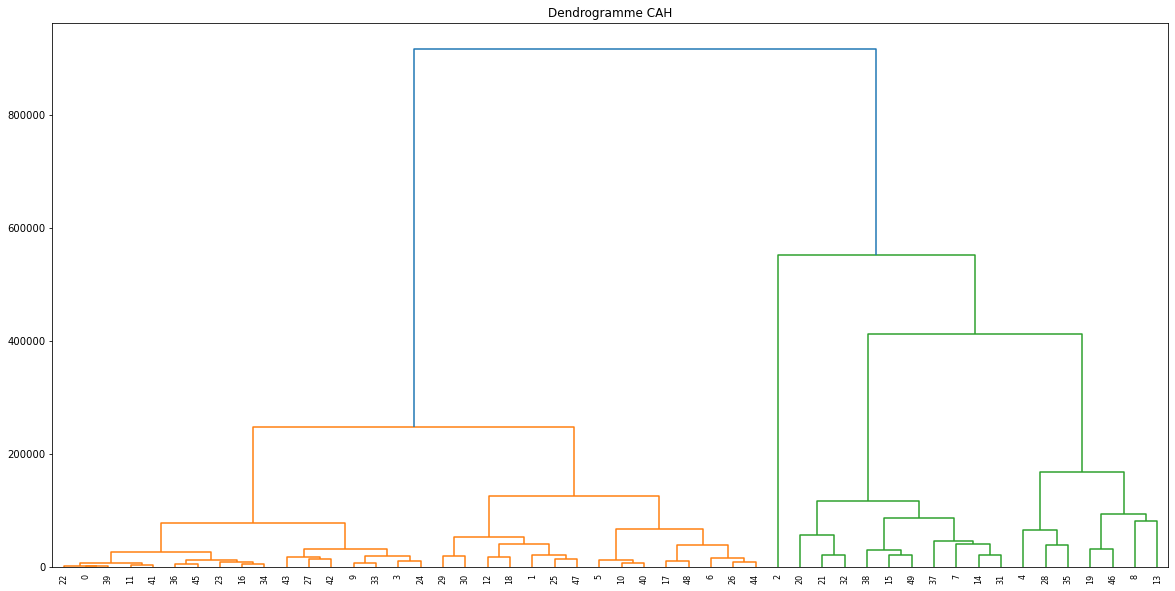

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour,kmean1_label,agglo_label,kmean2_label
visitorid,,,,,,,,,,,,,,
152963,3024,2304.0,371.0,278.0,349.0,620810.776,10347.0,172.45,2233.132288,37.0,0.62,2,2.0,2
530559,4328,3623.0,419.0,221.0,286.0,595864.357,9931.0,165.52,2696.218810,45.0,0.75,2,2.0,2
824842,480,345.0,113.0,16.0,22.0,388684.020,6478.0,107.97,24292.751250,405.0,6.75,13,0.0,2
899857,528,342.0,114.0,51.0,72.0,368777.972,6146.0,102.44,7230.940627,121.0,2.01,13,0.0,2
582525,26,15.0,6.0,4.0,5.0,336977.269,5616.0,93.60,84244.317250,1404.0,23.40,46,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404638,1,1.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00,0,1.0,1
1404639,2,2.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00,0,1.0,1
1404640,1,1.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000000,0.0,0.00,0,1.0,1


In [203]:
# CLUSTERING SUR STATS

k1 = KMeans(n_clusters=50).fit(stats)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

stats['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    stats.loc[stats['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = stats.groupby('agglo_label').mean()
new_stats = stats.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_stats)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

stats['kmean2_label'] = k2.labels_
stats

Text(0.5, 1.0, "Le nombre d'ajouts aux paniers par visiteur")

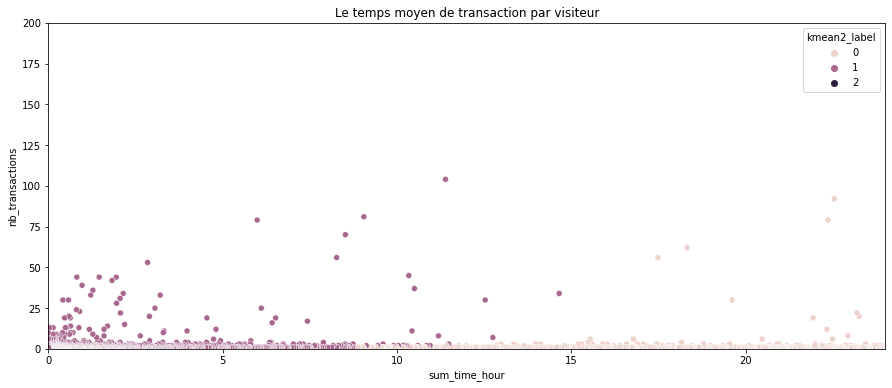

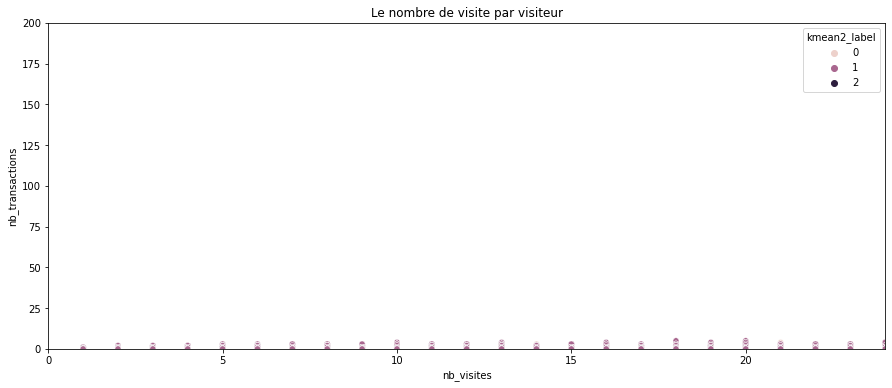

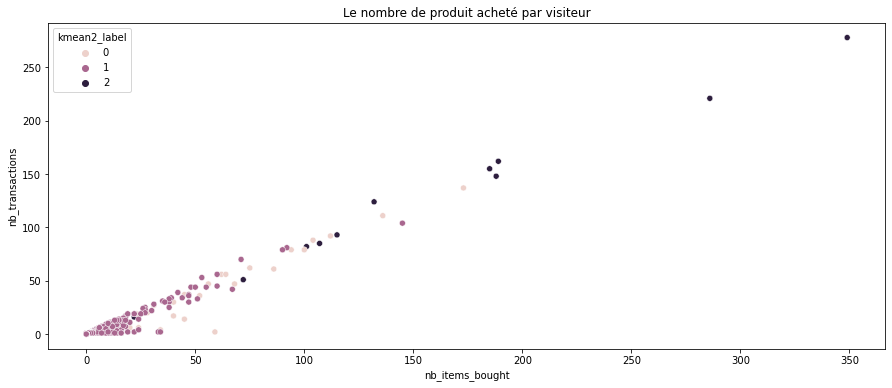

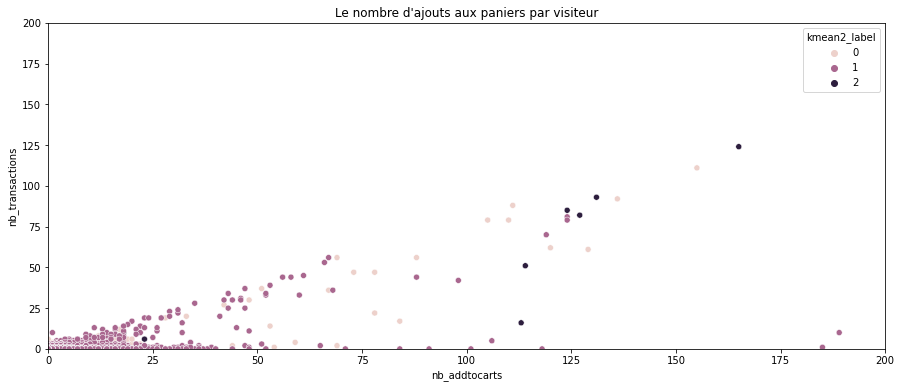

In [208]:
##### ANALYSES TABELEAU STATS (PAR VISITEUR)
plt.figure(figsize=(15,6))
sns.scatterplot(data=stats.loc[stats.nb_transactions > 0], x="sum_time_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps moyen de transaction par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_visites", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le nombre de transactions par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_items_bought", y="nb_transactions", hue="kmean2_label")
#plt.xlim(0, 24)
#plt.ylim(0, 600)
plt.title('Le nombre de produits achetés par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_addtocarts", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.title("Le nombre d'ajouts aux paniers par visiteur")

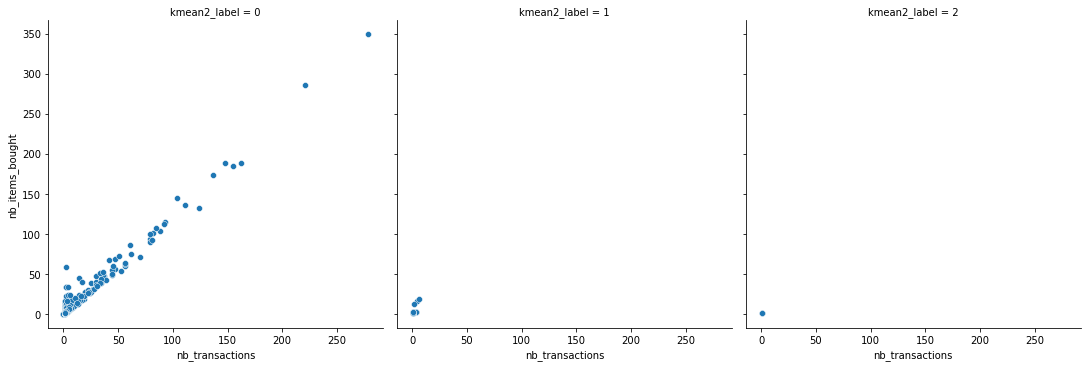

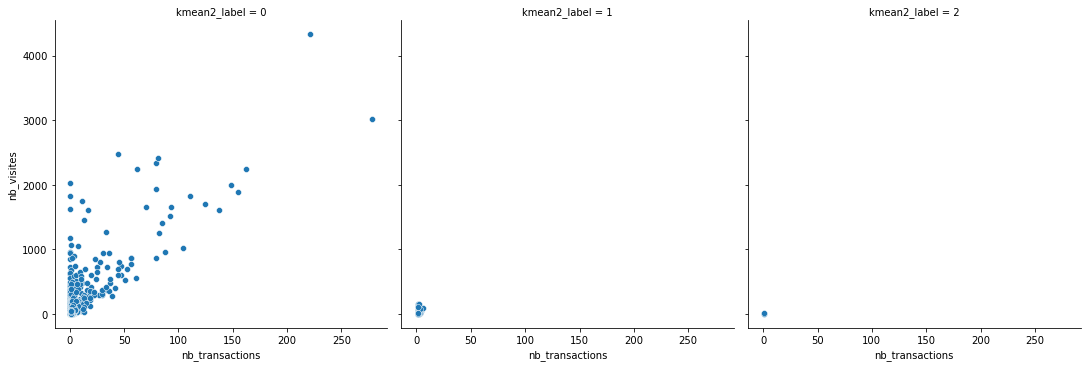

In [103]:
sns.relplot(
    data=stats, x="nb_transactions", y="nb_items_bought",
    col="kmean2_label",
    kind="scatter"
)

sns.relplot(
    data=stats, x="nb_transactions", y="nb_visites",
    col="kmean2_label",
    kind="scatter"
)

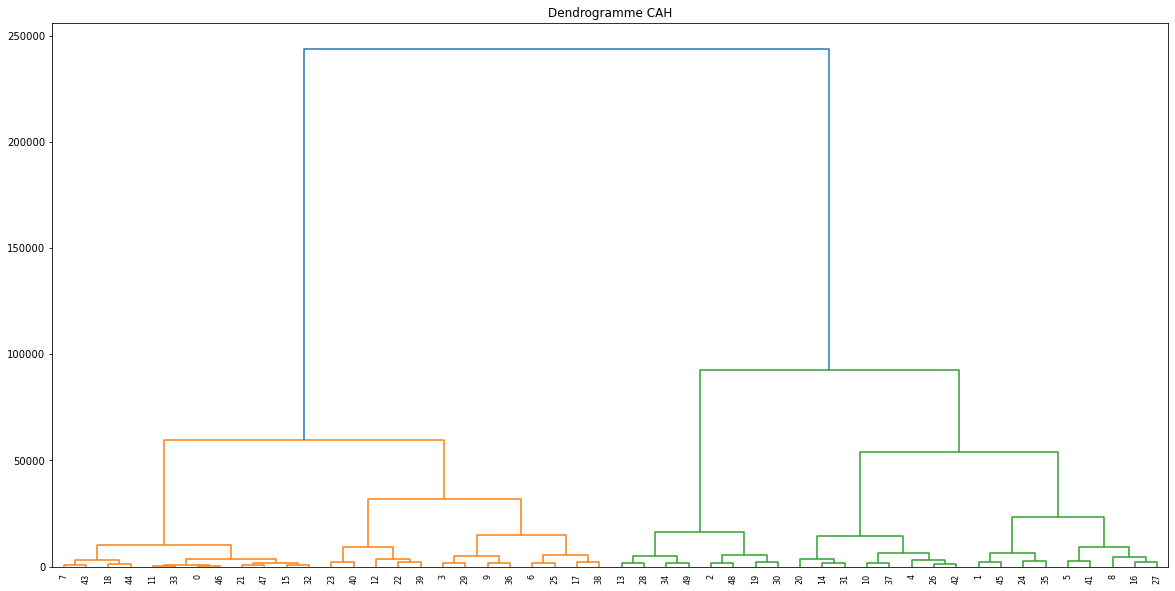

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,sum_time_second,sum_time_minute,sum_time_hour,kmean1_label,agglo_label,kmean2_label
transactionid_x,,,,,,
0.0,325.332,5.0,0.09,33,0.0,0
1.0,363.056,6.0,0.10,33,0.0,0
2.0,189.096,3.0,0.05,33,0.0,0
4.0,55.973,1.0,0.02,11,0.0,0
6.0,5.133,0.0,0.00,11,0.0,0
...,...,...,...,...,...,...
17667.0,45.523,1.0,0.01,11,0.0,0
17668.0,25.992,0.0,0.01,11,0.0,0
17669.0,89.100,1.0,0.02,11,0.0,0


In [183]:
# CLUSTERING SUR time_sum_tran
k1 = KMeans(n_clusters=50).fit(time_sum_tran)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_sum_tran['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    time_sum_tran.loc[time_sum_tran['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = time_sum_tran.groupby('agglo_label').mean()
new_time_sum_tran = time_sum_tran.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_time_sum_tran)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

time_sum_tran['kmean2_label'] = k2.labels_
time_sum_tran

Text(0.5, 1.0, 'Clustering')

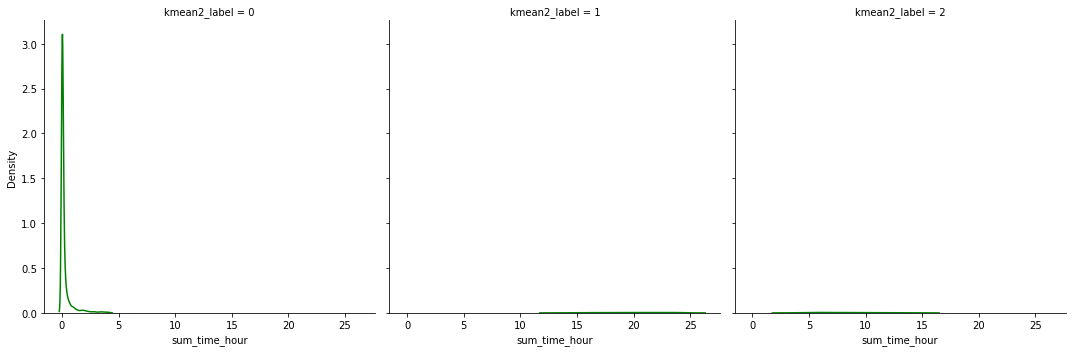

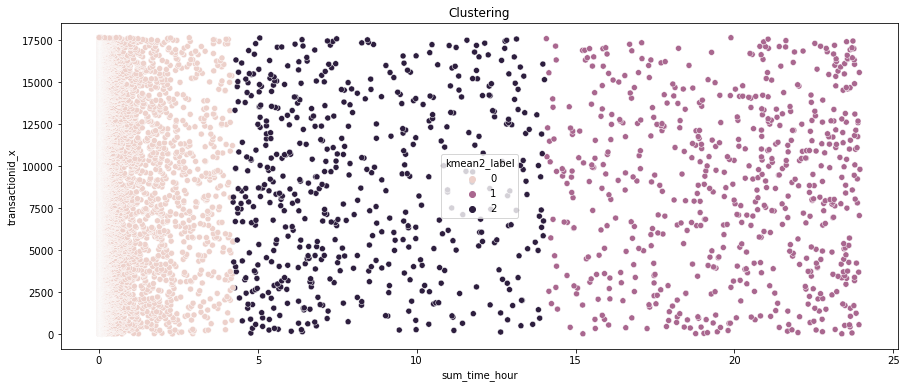

In [184]:
sns.displot(data=time_sum_tran, x="sum_time_hour", col="kmean2_label", kind="kde", color='green')

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_sum_tran, x="sum_time_hour", y=time_sum_tran.index, hue="kmean2_label",)
plt.title('Clustering')

Text(0.5, 1.0, 'Le temps total par transaction égale à moins de 10 minutes')

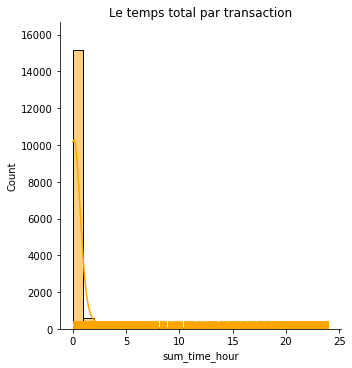

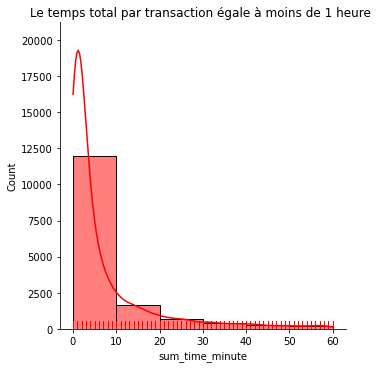

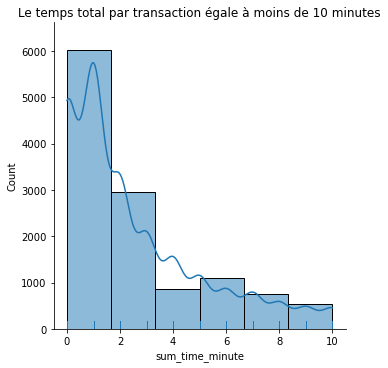

In [188]:
##### DATAVIZ ######
# Temps de Transactions moins d'une heure
sum_tran_1h = time_sum_tran.loc[round(time_sum_tran['sum_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
sum_trans_10min = sum_tran_1h.loc[round(sum_tran_1h['sum_time_minute']) <= 10]

sns.displot(time_sum_tran['sum_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Le temps total par transaction')

sns.displot(sum_tran_1h['sum_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Le temps total par transaction égale à moins de 1 heure ')
          
sns.displot(sum_trans_10min['sum_time_minute'], bins=6, kde=True, rug=True)
plt.title('Le temps total par transaction égale à moins de 10 minutes')

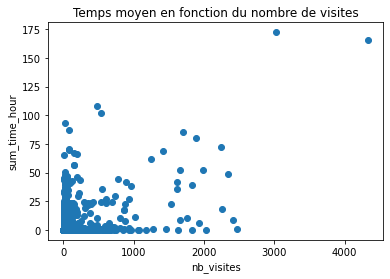

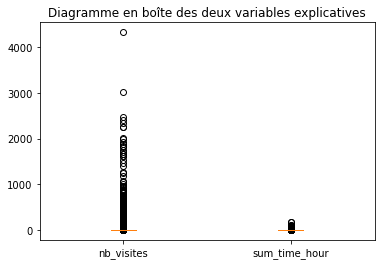

In [209]:
## création d'un nouveau df "stats_1" afin d'afficher un premier mapping
stats_1 = stats[['nb_visites','sum_time_hour']]
stats_1.head()

#affichage du graphique Temps moyen en fonction du nombre de visites
plt.scatter(stats_1['nb_visites'],stats_1['sum_time_hour'])
plt.ylabel('sum_time_hour')
plt.xlabel('nb_visites')
plt.title('Temps moyen en fonction du nombre de visites')
plt.show()

#boites à moustaches des deux variables
liste = [stats_1['nb_visites'], stats_1['sum_time_hour']]
plt.figure()
plt.title('Diagramme en boîte des deux variables explicatives')
plt.boxplot(liste, labels = ['nb_visites', 'sum_time_hour'])
plt.show()



In [210]:
# Methode des kmeans 
# Algorithme de K-means
kmeans = KMeans(n_clusters = 3)
kmeans.fit(stats_1)
# Centroids and labels
centroids = kmeans.cluster_centers_

#Visualisation des clusters et des centroïdes 
# Liste des couleurs
colors = ["g.","r.","b."]
# Graphique du nuage de points attribués au cluster correspondant
#for i in range(len(stats)):
for i in range (1000):
    plt.plot(stats_1.iloc[i,0], stats_1.iloc[i,1], colors[labels[i]], markersize = 10)
# Graphique des centroïdes
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue",s=30, linewidths = 1, zorder = 10)
plt.show()
centroids

NameError: name 'labels' is not defined

In [213]:
# Nombre de visiteurs par itemsid
items = df.groupby('itemid').agg({'visitorid':'count'})
items = items.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par itemid
items_view = df.loc[df['event'] == 'view'].groupby('itemid').agg({'itemid':'count'}) #df.loc[df['itemid'] == 9]
items_view = items_view.rename(columns={"itemid": "nb_views"})

# Nombre de addtocarts par itemid
items_addtocart = df.loc[df['event'] == 'addtocart'].groupby('itemid').agg({'itemid':'count'})
items_addtocart = items_addtocart.rename(columns={"itemid": "nb_addtocarts"})

# Nombre de transactions par itemid
items_transaction = df.loc[df['event'] == 'transaction'].groupby('itemid').agg({'itemid':'count'})
items_transaction = items_transaction.rename(columns={"itemid": "nb_transactions"})

# Merge dataframes
items = pd.merge(items, items_view, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_addtocart, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_transaction, left_index=True, right_index=True, how='left')

# Merge avec temps moyen passé
items = items.fillna(0)
items = items.sort_values('nb_transactions', ascending=False)
items

,nb_visites,nb_views,nb_addtocarts,nb_transactions
itemid,,,,
461686,2978,2539.0,306.0,133.0
119736,893,752.0,44.0,97.0
213834,402,293.0,17.0,92.0
312728,1155,947.0,162.0,46.0
7943,1489,1346.0,97.0,46.0
...,...,...,...,...
159357,1,1.0,0.0,0.0
159359,13,13.0,0.0,0.0
159362,2,2.0,0.0,0.0


In [214]:
# SELECT 500 PRODUITS PLUS ACHETES, PLUS MIS AU PANIER, PLUS VUS
n_produits = 500

# les n_produits produits plus achetés
top_produits_vendus = items.sort_values(by='nb_transactions', ascending=False).head(n_produits)
top_produits_vendus['cat_top_vendus'] = "1"
top_produits_vendus = top_produits_vendus.drop(columns=['nb_visites', 'nb_views', 'nb_addtocarts'])

# les n_produits produits plus mis au panier
top_produits_paniers = items.sort_values(by='nb_addtocarts', ascending=False).head(n_produits)
top_produits_paniers['cat_top_mis_panier'] = "1"
top_produits_paniers = top_produits_paniers.drop(columns=['nb_visites', 'nb_views', 'nb_transactions'])

# les n_produits produits plus vus
top_produits_vus = items.sort_values(by='nb_views', ascending=False).head(n_produits)
top_produits_vus['cat_top_vus'] = "1"
top_produits_vus = top_produits_vus.drop(columns=['nb_visites', 'nb_addtocarts', 'nb_transactions'])

# Merge les 3 dataframes OUTER
top_produits = pd.merge(top_produits_vendus, top_produits_paniers, left_index=True, right_index=True, how='outer')
top_produits = pd.merge(top_produits, top_produits_vus, left_index=True, right_index=True, how='outer')

top_produits = top_produits[['cat_top_vus', 'cat_top_mis_panier', 'cat_top_vendus']]
top_produits = top_produits.fillna(0)
top_produits

,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,
546,1,1,1
829,0,1,1
869,1,1,1
1684,0,0,1
2416,0,1,1
...,...,...,...
465511,1,1,0
465522,0,1,1
465751,0,0,1


In [217]:
top_produits_merged = pd.merge(items, top_produits, left_index=True, right_index=True, how='left')
top_produits_merged = top_produits_merged.sort_values(by=['nb_transactions'], ascending=False)
top_produits_merged = top_produits_merged.fillna(0)
top_produits_merged 

,nb_visites,nb_views,nb_addtocarts,nb_transactions,kmean1_label,agglo_label,kmean2_label,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,,,,,,,,
461686,2978,2539.0,306.0,133.0,23,1.0,1,1,1,1
119736,893,752.0,44.0,97.0,5,0.0,1,1,1,1
213834,402,293.0,17.0,92.0,49,0.0,2,0,1,1
312728,1155,947.0,162.0,46.0,43,2.0,1,1,1,1
7943,1489,1346.0,97.0,46.0,35,2.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
442427,47,46.0,1.0,0.0,18,0.0,0,0,0,0
442428,2,2.0,0.0,0.0,28,0.0,0,0,0,0
442431,136,133.0,3.0,0.0,2,0.0,2,0,0,0


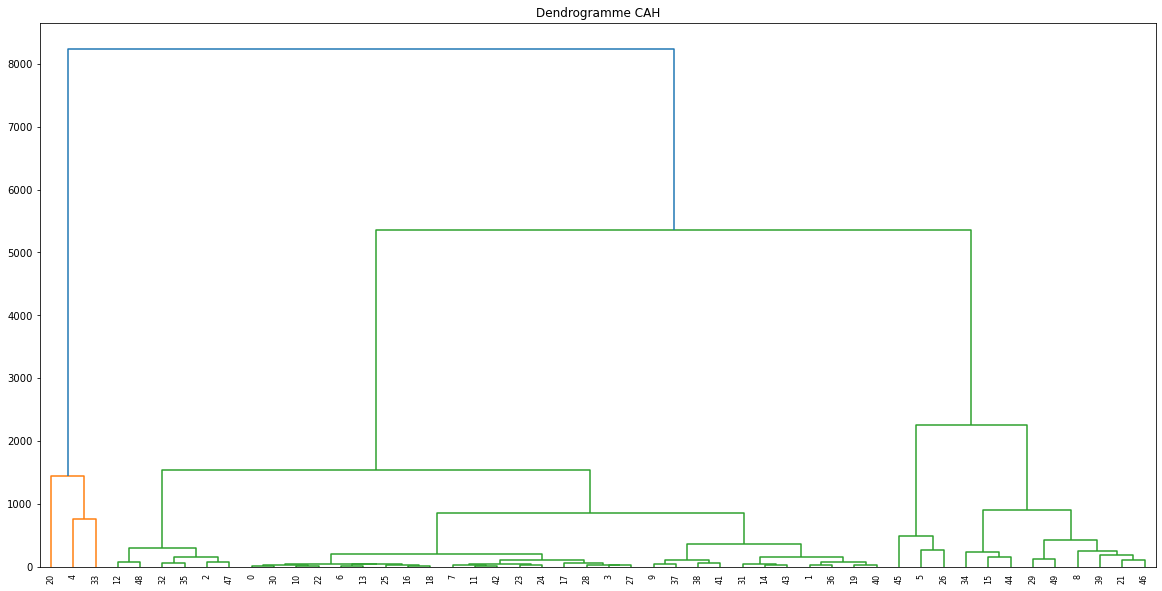

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,kmean1_label,agglo_label,kmean2_label
itemid,,,,,,,
461686,2978,2539.0,306.0,133.0,4,1.0,1
119736,893,752.0,44.0,97.0,29,0.0,1
213834,402,293.0,17.0,92.0,47,2.0,0
312728,1155,947.0,162.0,46.0,44,0.0,1
7943,1489,1346.0,97.0,46.0,5,0.0,1
...,...,...,...,...,...,...,...
159357,1,1.0,0.0,0.0,6,2.0,2
159359,13,13.0,0.0,0.0,18,2.0,2
159362,2,2.0,0.0,0.0,0,2.0,2


In [218]:
# CLUSTERING SUR STATS

k1 = KMeans(n_clusters=50).fit(items)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

items['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    items.loc[items['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = items.groupby('agglo_label').mean()
new_items = items.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_items)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

items['kmean2_label'] = k2.labels_
items

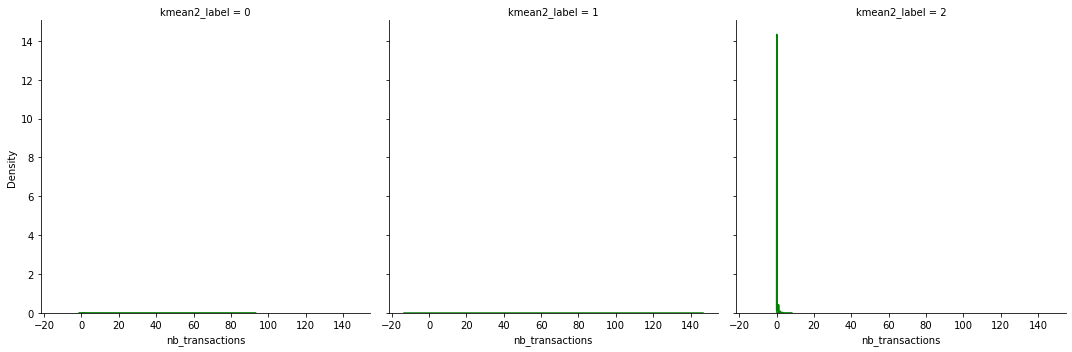

In [219]:
sns.displot(data=items, x="nb_transactions", col="kmean2_label", kind="kde", color='green')


Text(0.5, 1.0, 'Clustering')

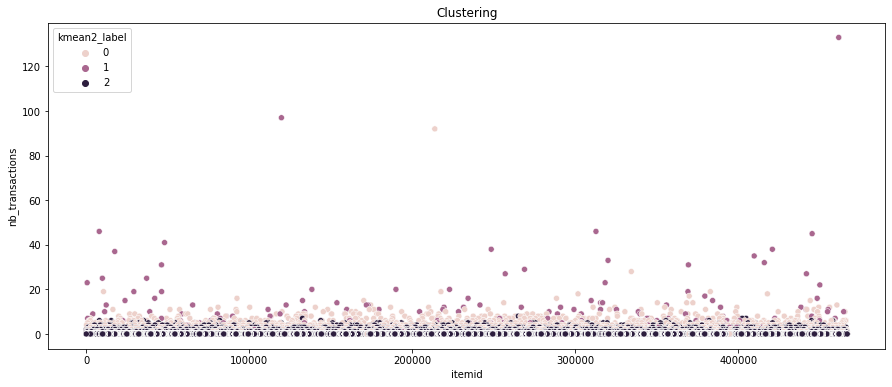

In [221]:
import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=items, y="nb_transactions", x=items.index, hue="kmean2_label",)
plt.title('Clustering')